In [4]:
import cv2

original_img = cv2.imread('./images/flappy_bird.png')

In [5]:
original_img

array([[[ 74, 189, 135],
        [ 74, 189, 135],
        [ 74, 189, 135],
        ...,
        [206, 193, 131],
        [206, 193, 131],
        [206, 193, 131]],

       [[ 74, 189, 135],
        [ 74, 189, 135],
        [ 74, 189, 135],
        ...,
        [206, 193, 131],
        [206, 193, 131],
        [206, 193, 131]],

       [[ 74, 189, 135],
        [ 74, 189, 135],
        [ 74, 189, 135],
        ...,
        [206, 193, 131],
        [206, 193, 131],
        [206, 193, 131]],

       ...,

       [[ 74, 189, 135],
        [ 74, 189, 135],
        [ 74, 189, 135],
        ...,
        [164, 212, 163],
        [164, 213, 163],
        [164, 213, 163]],

       [[ 74, 189, 135],
        [ 74, 189, 135],
        [ 74, 189, 135],
        ...,
        [149, 206, 149],
        [148, 207, 149],
        [148, 207, 149]],

       [[ 74, 189, 135],
        [ 74, 189, 135],
        [ 74, 189, 135],
        ...,
        [138, 204, 139],
        [137, 204, 139],
        [136, 204, 139]]

In [ ]:
import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

def preprocess(prev_frame: Path | str, current_frame: Path | str) -> Path | str:
    # Read the input frames to get a 3D array: (rows x cols x channels)
    prev_img = cv2.imread(str(prev_frame))
    current_img = cv2.imread(str(current_frame))
    new_frame = np.maximum(prev_img, current_img)
    gray_img = cv2.cvtColor(new_frame, cv2.COLOR_BGR2GRAY)
    rescaled_img = cv2.resize(gray_img, (84, 84), interpolation=cv2.INTER_AREA)
    plt.imshow(rescaled_img, cmap="gray", interpolation="nearest")
    plt.show()
    return rescaled_img

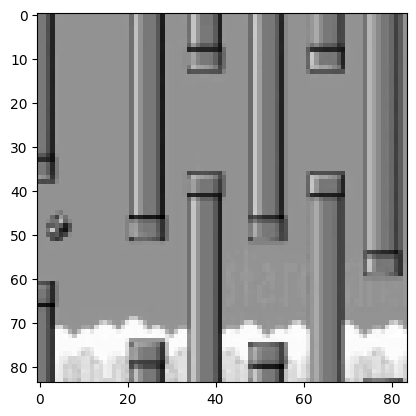

array([[160, 160, 134, ..., 125, 141, 176],
       [160, 160, 135, ..., 125, 142, 178],
       [160, 160, 135, ..., 125, 143, 177],
       ...,
       [160, 160, 134, ..., 236, 230, 219],
       [160, 160, 134, ..., 232, 229, 219],
       [160, 160, 134, ..., 139, 133, 206]], shape=(84, 84), dtype=uint8)

In [13]:
prev_frame = "./images/flappy_bird.png"
current_frame = "./images/flappy_bird.png"

preprocess(prev_frame, current_frame)

In [10]:
def conv2d_output_size(input_size, kernel_size, stride, padding=0):
    """
    Calculate the output size of a 2D convolutional layer.
    
    Formula: output_size = (input_size - kernel_size + 2*padding) / stride + 1
    
    Args:
        input_size: Input height/width (int or tuple)
        kernel_size: Kernel size (int or tuple)
        stride: Stride (int or tuple)
        padding: Padding (int or tuple, default=0)
    
    Returns:
        Output size (int or tuple)
    """
    if isinstance(input_size, tuple):
        # Handle tuple input (height, width)
        h, w = input_size
        
        # Handle kernel_size - convert int to tuple if needed
        if isinstance(kernel_size, tuple):
            k_h, k_w = kernel_size
        else:
            k_h = k_w = kernel_size
        
        # Handle stride - convert int to tuple if needed
        if isinstance(stride, tuple):
            s_h, s_w = stride
        else:
            s_h = s_w = stride
        
        # Handle padding - convert int to tuple if needed
        if isinstance(padding, tuple):
            p_h, p_w = padding
        else:
            p_h = p_w = padding
        
        o_h = (h - k_h + 2 * p_h) // s_h + 1
        o_w = (w - k_w + 2 * p_w) // s_w + 1
        return (int(o_h), int(o_w))
    else:
        # Handle single dimension
        k = kernel_size if isinstance(kernel_size, int) else kernel_size[0]
        s = stride if isinstance(stride, int) else stride[0]
        p = padding if isinstance(padding, int) else padding[0]
        return int((input_size - k + 2 * p) // s + 1)

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [14]:
class DQN(nn.Module):
    """
    Deep Q-Network architecture as described in the DQN paper.
    
    Architecture:
    - Input: 4 stacked grayscale frames (84x84 each)
    - CONV1: 32 filters, 8x8 kernel, stride 4, ReLU
    - CONV2: 64 filters, 4x4 kernel, stride 2, ReLU
    - CONV3: 64 filters, 3x3 kernel, stride 1, ReLU
    - FC: 512 hidden units, ReLU
    - Output: num_actions (one Q-value per action)
    """
    
    def __init__(self, num_actions=2, input_size=(84, 84)):
        super(DQN, self).__init__()
        self.num_actions = num_actions
        
        # First convolutional layer: 32 filters, 8x8 kernel, stride 4
        self.conv1 = nn.Conv2d(in_channels=4, out_channels=32, kernel_size=8, stride=4)
        
        # Calculate output size after conv1
        conv1_output_size = conv2d_output_size(input_size, kernel_size=8, stride=4)
        
        # Second convolutional layer: 64 filters, 4x4 kernel, stride 2
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2)
        
        # Calculate output size after conv2
        conv2_output_size = conv2d_output_size(conv1_output_size, kernel_size=4, stride=2)
        
        # Third convolutional layer: 64 filters, 3x3 kernel, stride 1
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1)
        
        # Calculate output size after conv3
        conv3_output_size = conv2d_output_size(conv2_output_size, kernel_size=3, stride=1)
        
        # Calculate flattened feature size dynamically
        flattened_size = 64 * conv3_output_size[0] * conv3_output_size[1]
        
        # Fully connected layer: 512 hidden units
        self.fc1 = nn.Linear(flattened_size, 512)
        
        # Output layer: one Q-value per action
        self.fc2 = nn.Linear(512, num_actions)
        
    def forward(self, x):
        """
        Forward pass through the network.
        
        Args:
            x: Input tensor of shape (batch_size, 4, 84, 84)
            
        Returns:
            Q-values for each action, shape (batch_size, num_actions)
        """
        # First convolutional layer + ReLU
        x = F.relu(self.conv1(x))
        
        # Second convolutional layer + ReLU
        x = F.relu(self.conv2(x))
        
        # Third convolutional layer + ReLU
        x = F.relu(self.conv3(x))
        
        # Flatten the feature map
        x = x.view(x.size(0), -1)
        
        # Fully connected layer + ReLU
        x = F.relu(self.fc1(x))
        
        # Output layer (Q-values for each action)
        x = self.fc2(x)
        
        return x

In [15]:
# Test the DQN model architecture
# Create a model instance
model = DQN(num_actions=2)

# Create a dummy input: batch_size=1, 4 stacked frames, 84x84 grayscale
dummy_input = torch.randn(1, 4, 84, 84)

# Forward pass
with torch.no_grad():
    output = model(dummy_input)

print(f"Model architecture:")
print(model)
print(f"\nInput shape: {dummy_input.shape}")
print(f"Output shape: {output.shape}")
print(f"Expected output shape: (1, 2) - one Q-value per action")
print(f"\nQ-values: {output}")


Model architecture:
DQN(
  (conv1): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=3136, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)

Input shape: torch.Size([1, 4, 84, 84])
Output shape: torch.Size([1, 2])
Expected output shape: (1, 2) - one Q-value per action

Q-values: tensor([[0.0080, 0.0024]])
